In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import gc
import sys
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
#from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from pylab import rcParams


rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Impago"]

In [2]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
                # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)     
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [12]:
#1- Cargo fichero bureau_balance.csv y veo cabecera 
BureauBalance = pd.read_csv('/Users/LENOVO/Downloads/bureau_balance.csv', delimiter= ',' , header=0)
#BureauBalance.head()
#BureauBalance.describe()
#BureauBalance = BureauBalance.dropna()
BureauBalance


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [13]:
#BureauBalance.dtypes.value_counts()

In [14]:
#Función cuenta variables categoricas
def count_categoricas(df, group_var, df_name):
    """Calcula conteos y conteos normalizados para cada observación
    de `group_var` de cada categoría única en cada variable categórica
    
    Parámetros
    --------
    df : dataframe 
         El marco de datos para calcular el valor cuenta.
        
    group_var : string
        La variable por la cual agrupar el marco de datos. Para cada unico
        valor de esta variable, el marco de datos final tendrá una fila
        
    df_name : string
        Variable agregada al frente de los nombres de columna para realizar un seguimiento de las columnas

    
    Return
    --------
    categorical : dataframe
        Un marco de datos con recuentos y recuentos normalizados de cada categoría única en cada variable categórica
        con una fila por cada valor único de `group_var`
        
    """
    
    #Seleccion de las columnas categóricas
    categorica = pd.get_dummies(df.select_dtypes('object'))

    # Pone la de identificación en la columna
    categorica[group_var] = df[group_var]

    # Agrupa por el grupo var y calcula la suma y la media
    categorica = categorica.groupby(group_var).agg(['sum','mean'])
    
    column_names = []
    
    # Itera a través de las columnas en el nivel 0
    for var in categorica.columns.levels[0]:
        # Iterar a través de las estadísticas en el nivel 1
        for stat in ['count', 'count_norm']:
            # Genera un nuevo nombre de columna
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorica.columns = column_names
    
    return categorica

In [15]:
#Función cuenta variables numéricas
def agg_numericas(df, group_var, df_name):
    """Agrega los valores numéricos en un marco de datos. Esto puede
    se utilizará para crear características para cada instancia de la variable de agrupación.
    
    Parameters
    --------
        df (dataframe): 
            el marco de datos para calcular las estadísticas
        group_var (string): 
            la variable por la cual agrupar df
        df_name (string):            
            la variable utilizada para renombrar las columnas
        
    Return
    --------
        agg (dataframe): 
            un marco de datos con las estadísticas agregadas para
            Todas las columnas numéricas. Cada instancia de la variable de agrupación tendrá
            las estadísticas (media, min, max, suma; actualmente admitidas) calculadas.
            Las columnas también se renombran para realizar un seguimiento de las características creadas.
    
    """
    # Elimina variables de identificación que no sean variables de agrupación
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Agrupa por la variable especificada y calcula las estadísticas
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

   #Crea nuevos nombres de columna
    columns = [group_var]

   #Itera a través de los nombres de las variables
    for var in agg.columns.levels[0]:
        # Salta la variable de agrupación
        if var != group_var:
            #Itera a través de los nombres de estadísticas
            for stat in agg.columns.levels[1][:-1]:
                # Hace un nuevo nombre de columna para la variable y estadística
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [16]:
#Recuento de cada tipo de estado de las variables CATEGORICAS para cada préstamo anterior por campo 'SK_ID_BUREAU'
BureauBalance_counts = count_categoricas(BureauBalance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#BureauBalance_counts.head()
#BureauBalance_counts.describe()
#BureauBalance_counts


In [17]:
# Calculo estadísticas de recuento de variables NUMERICAS para cada 'SK_ID_BUREAU' 
BureauBalance_agg = agg_numericas(BureauBalance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#BureauBalance_agg.head()
#BureauBalance_agg.describe()
#BureauBalance_agg


In [18]:
# Dataframe agrupando BureauBalance_agg con BureauBalance_counts por préstamo anterior
BureauBalance_by_loan = BureauBalance_agg.merge(BureauBalance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
#BureauBalance_by_loan.head()
#BureauBalance_by_loan.describe()
#BureauBalance_by_loan

In [19]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [20]:
#2- Cargo fichero bureau.csv
Bureau = pd.read_csv('/Users/LENOVO/Downloads/bureau.csv', delimiter= ',' , header=0)
#Bureau.head()
#Bureau.describe()
#Bureau = Bureau.dropna()
Bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [21]:
# Fusion para incluir la SK_ID_CURR
BureauBalance_by_loanMerge = BureauBalance_by_loan.merge(Bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
#BureauBalance_by_loanMerge
#BureauBalance_by_loanMerge.head()


In [22]:
##***** Agrega las estadísticas de prestamos por 'SK_ID_CURR'. Elimina columna 'SK_ID_BUREAU'. Para unir a train****
BureauBalance_by_client = agg_numericas(BureauBalance_by_loanMerge.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
#BureauBalance_by_client.head()
#BureauBalance_by_client.describe()
BureauBalance_by_client

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.000000,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.000000,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.000000,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.000000,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.000000,1.018182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134537,456247.0,11,29.090909,82,10,320,11,-19.863636,-4.5,-53.0,...,11,3.181818,5,0,35.0,11,0.168838,0.500000,0.000000,1.857222
134538,456250.0,3,29.000000,33,26,87,3,-14.000000,-12.5,-16.0,...,3,16.666667,26,0,50.0,3,0.617216,0.928571,0.000000,1.851648
134539,456253.0,4,29.250000,31,24,117,4,-14.125000,-11.5,-15.0,...,4,3.250000,13,0,13.0,4,0.135417,0.541667,0.000000,0.541667
134540,456254.0,1,37.000000,37,37,37,1,-18.000000,-18.0,-18.0,...,1,0.000000,0,0,0.0,1,0.000000,0.000000,0.000000,0.000000


In [23]:
#BureauBalance_by_client.dtypes.value_counts()

In [24]:
# Missing values statistics
#missing_values = missing_values_table(BureauBalance_by_client)
#missing_values.head(20)

In [25]:
#corrs = BureauBalance_by_client.corr()
#corrs

In [26]:
#corrs = corrs.sort_values('client_bureau_balance_MONTHS_BALANCE_count_mean', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['client_bureau_balance_MONTHS_BALANCE_count_mean'].head(10))

In [27]:
#2- Cargo fichero bureau.csv
#Bureau = pd.read_csv('/Users/LENOVO/Downloads/bureau.csv', delimiter= ',' , header=0)
#Bureau = Bureau.dropna()
#Bureau
Bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [28]:
#Se cuentan los prestamos anteriores por campo SK_ID_BUREAU y se agrupan por 'SK_ID_CURR'
Previous_loan_counts = Bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
#Previous_loan_counts

In [29]:
#Genera recuento y estadisticas de las variables para cada préstamo anterior eliminando columna 'SK_ID_BUREAU'y
#agrupando por campo 'SK_ID_CURR'
Bureau_agg = Bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR',
as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index() 
#Bureau_agg.head()
#Bureau_agg

In [30]:
#Funcion para cambiar nombres en el df
# Lista de nombres de columna
columns = ['SK_ID_CURR']

#Itera a través de los nombres de las variables
for var in Bureau_agg.columns.levels[0]:
    # Salta el nombre de identificación
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in Bureau_agg.columns.levels[1][:-1]:
            # Itera a través de los nombres de estadísticas
            columns.append('bureau_%s_%s' % (var, stat))

In [31]:
#**** Asigna la lista de nombres de columnas como los nombres de columna del marco de datos***
Bureau_agg.columns = columns
#Bureau_agg.head()
Bureau_agg

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.000,24817.500
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.000,0.000
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.000
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.000
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.000,4261.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,13,-1667.076923,-483,-2713,-21672,13,0.0,0,0,...,13,-1064.538462,-12,-2498,-13839,0,NaN,NaN,NaN,0.000
305807,456250,3,-862.000000,-760,-1002,-2586,3,0.0,0,0,...,3,-60.333333,-23,-127,-181,3,154567.965000,384147.0,27757.395,463703.895
305808,456253,4,-867.500000,-713,-919,-3470,4,0.0,0,0,...,4,-253.250000,-5,-701,-1013,3,58369.500000,58369.5,58369.500,175108.500
305809,456254,1,-1104.000000,-1104,-1104,-1104,1,0.0,0,0,...,1,-401.000000,-401,-401,-401,1,0.000000,0.0,0.000,0.000


In [32]:
categorical = pd.get_dummies(Bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = Bureau['SK_ID_CURR']
#categorical.head()
categorical

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,259355
1716424,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100044
1716425,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100044
1716426,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,246829


In [175]:
#categorical_grouped.columns.levels[0][:10]

In [176]:
#categorical_grouped.columns.levels[1]

In [33]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [34]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [35]:
# Dataframe agrupando Bureau_agg con categorical_grouped por préstamo anterior
BureauAgregado_by_loan = categorical_grouped.merge(Bureau_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
#BureauAgregado_by_loan.head()
#BureauAgregado_by_loan.describe()
BureauAgregado_by_loan

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
100001.0,3.0,0.428571,0.0,0.0,4.0,0.571429,0.0,0.0,7.0,1.0,...,6.0,-736.000000,-26.0,-2425.0,-4416.0,5.0,53336.700000,161203.5,16380.0,266683.5
100002.0,2.0,0.250000,0.0,0.0,6.0,0.750000,0.0,0.0,8.0,1.0,...,1.0,-1074.000000,-1074.0,-1074.0,-1074.0,0.0,NaN,NaN,NaN,0.0
100003.0,1.0,0.250000,0.0,0.0,3.0,0.750000,0.0,0.0,4.0,1.0,...,8.0,-789.500000,-12.0,-1805.0,-6316.0,0.0,NaN,NaN,NaN,0.0
100004.0,0.0,0.000000,0.0,0.0,2.0,1.000000,0.0,0.0,2.0,1.0,...,4.0,-193.000000,-8.0,-413.0,-772.0,0.0,NaN,NaN,NaN,0.0
100005.0,2.0,0.666667,0.0,0.0,1.0,0.333333,0.0,0.0,3.0,1.0,...,11.0,-535.454545,-4.0,-2125.0,-5890.0,0.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,-560.600000,-29.0,-898.0,-2803.0,0.0,NaN,NaN,NaN,0.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,-430.666667,-5.0,-1201.0,-2584.0,5.0,33684.300000,44140.5,18000.0,168421.5
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,-626.000000,-3.0,-1651.0,-7512.0,7.0,16089.942857,29217.6,0.0,112629.6
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,-727.666667,-117.0,-1301.0,-2183.0,0.0,NaN,NaN,NaN,0.0


In [36]:
# Missing values statistics
#missing_values = missing_values_table(BureauAgregado_by_loan)
#missing_values.head(20)

In [37]:
#corrs = BureauAgregado_by_loan.corr()
#corrs

In [38]:
#corrs = corrs.sort_values('bureau_AMT_ANNUITY_max', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['bureau_AMT_ANNUITY_max'].head(10))

In [39]:
def agg_numeric(df, parent_var, df_name):
    """
    Agrupa y agrega los valores numéricos en un marco de datos hijo
    por la variable padre.
    
    Parameters
    --------
        df (dataframe): 
            el marco de datos hijo para calcular las estadísticas en
        parent_var (string): 
            La variable principal utilizada para agrupar y agregar
        df_name (string): 
            la variable utilizada para renombrar las columnas
        
    Return
    --------
        agg (dataframe): 
            un marco de datos con las estadísticas agregadas por el `parent_var` para
            Todas las columnas numéricas. Cada observación de la variable principal tendrá
            una fila en el marco de datos con la variable principal como índice.
            Las columnas también se renombran usando el `df_name`. Columnas con todos los duplicados.
            Se eliminan los valores.
    
    """
      
    # Elimina variables de identificación que no sean variables de agrupación
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Solo toma las variables numéricas
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids
    
    # Agrupa por la variable especificada y calcula las estadísticas
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Necesita crear nuevos nombres de columna
    columns = []

    # Itera a través de los nombres de las variables
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Itera a través de los nombres de estadísticas
            for stat in agg.columns.levels[1]:
                # Genera un nuevo nombre de columna para la variable y estadística
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Elimina las columnas con todos los valores redundantes
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [40]:
def agg_categorical(df, parent_var, df_name):
    """
    Agrega las características categóricas en un marco de datos hijo
    para cada observación de la variable principal.
    
    Parameters
    --------
    df : dataframe 
        El marco de datos para calcular el valor cuenta.
        
    parent_var : string
        La variable por la cual agrupar y agregar el marco de datos. Para cada unico
        valor de esta variable, el marco de datos final tendrá una fila
        
    df_name : string
       Variable agregada al frente de los nombres de columna para realizar un seguimiento de las columnas

    
    Return
    --------
    categorical : dataframe
        Un marco de datos con estadísticas agregadas para cada observación de parent_var
        Las columnas también se renombran y las columnas con valores duplicados se eliminan.
        
    """
       
    # Selecciona las columnas categóricas
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Asegura poner la identificación de identificación en la columna
    categorical[parent_var] = df[parent_var]

    # Agrupa por el grupo var y calcula la suma y la media
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterar a través de las columnas en el nivel 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Iterar a través de las estadísticas en el nivel 1
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
        
    # Elimina columnas duplicadas por valores
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [41]:
def aggregate_client(df, group_vars, df_names):
    """Agregar un marco de datos con datos a nivel de préstamo
    a nivel del cliente
    
    Args:
        df (dataframe): datos a nivel de préstamo
        group_vars (lista de dos cadenas): agrupando variables para el préstamo
        y luego el cliente (ejemplo ['SK_ID_PREV', 'SK_ID_CURR'])
        nombres (lista de dos cadenas): nombres para llamar a las columnas resultantes
        (ejemplo ['efectivo', 'cliente'])
        
    Returns:
        df_client (dataframe): estadísticas numéricas agregadas a nivel del cliente.
       Cada cliente tendrá una sola fila con todos los datos numéricos agregados
    """
    
    # Agrega las columnas numéricas
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # Si hay variables categóricas
    if any(df.dtypes == 'category'):
    
        # Cuenta las columnas categóricas
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Fusiona la numérica y categórica
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Combina para obtener la identificación del cliente en el marco de datos
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Elimina la identificación del préstamo
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Agrega estadísticas numéricas por columna
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No hay variables categóricas
    else:
        # Combina para obtener la identificación del cliente en el marco de datos
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Elimina la identificación del préstamo
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
                
        # Agrega estadísticas numéricas por columna
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Gestión de la memoria
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [42]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [43]:
#3-Cargo fichero installments_payments.csv y veo cabecera
installments_payments = pd.read_csv('/Users/LENOVO/Downloads/installments_payments.csv', delimiter= ',' , header=0)
#installments_payments.head()
#installments_payments.describe()
#installments_payments = installments_payments.dropna()
installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [44]:
#installments_payments.dtypes.value_counts()

In [45]:
##***** Agrega las estadísticas de prestamos por 'SK_ID_CURR'. Elimina columna 'SK_ID_PREV'****
installments_payments_by_client = aggregate_client(installments_payments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
#installments_payments_by_client.head()
installments_payments_by_client

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,27746.775,27746.775,29250.900,29250.900,41195.925,41195.925,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4.394101e+06,4.394101e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,16071.750,16071.750,21288.465,21288.465,21288.465,21288.465,3.172190e+04,3.172190e+04,6.386540e+04,6.386540e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,43318.800,43318.800,56161.845,56161.845,56161.845,56161.845,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-7658.0,-5880.0,-1659.0,-1470.0,-1094.0,-840.0,-266.0,-210.0,-840.0,-1094.0,...,46241.370,46241.370,52450.470,52450.470,52450.470,52450.470,8.970507e+04,8.970507e+04,3.671533e+05,3.671533e+05
456252,-86178.0,-86076.0,-14820.0,-14796.0,-14363.0,-14346.0,-13962.0,-13896.0,-14346.0,-14363.0,...,60281.280,60281.280,60419.205,60419.205,60419.205,60419.205,6.044679e+04,6.044679e+04,3.625152e+05,3.625152e+05
456253,-160696.0,-159541.0,-34151.0,-34001.0,-33424.0,-33221.0,-32708.0,-32471.0,-13820.0,-13883.0,...,41805.990,61529.040,33413.760,33413.760,57622.815,61595.910,6.166174e+04,6.166174e+04,3.048921e+05,3.247575e+05


In [46]:
# Missing values statistics
#missing_values = missing_values_table(installments_payments_by_client)
#missing_values.head(20)

In [47]:
#corrs = installments_payments_by_client.corr()
#corrs

In [48]:
#corrs = corrs.sort_values('client_installments_DAYS_INSTALMENT_mean_sum', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['client_installments_DAYS_INSTALMENT_mean_sum'].head(10))

In [49]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [50]:
#4-Cargo fichero POS_CASH_balance.csv y veo cabecera
POS_CASH_balance = pd.read_csv('/Users/LENOVO/Downloads/POS_CASH_balance.csv', delimiter= ',' , header=0)
#POS_CASH_balance.head()
#POS_CASH_balance.describe()
#POS_CASH_balance = POS_CASH_balance.dropna()
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [51]:
#POS_CASH_balance.dtypes.value_counts()

In [52]:
##***** Agrega las estadísticas de cash por 'SK_ID_CURR'. Elimina columna 'SK_ID_PREV'****
POS_CASH_balance_by_client = aggregate_client(POS_CASH_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
#POS_CASH_balance_by_client.head()
POS_CASH_balance_by_client

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_MONTHS_BALANCE_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28,28.0,36.0,36.000,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,0,456.0,456.0,456.000,456.0,361,361,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,0,288.0,248.0,283.000,288.0,272,272,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,0,16.0,12.0,15.000,16.0,16,16,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,0,132.0,99.0,128.700,132.0,110,110,121,792.0,1287.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-405,-81,-45.0,-9,-45,-45.000000,-45,-9,-5.0,-1,...,0,72.0,63.0,70.875,72.0,72,72,81,315.0,567.0
456252,-3871,-574,-553.0,-532,-553,-553.000000,-553,-82,-79.0,-76,...,0,42.0,42.0,42.000,42.0,49,49,49,147.0,294.0
456253,-7746,-1389,-1347.0,-1305,-549,-455.647059,-378,-96,-94.5,-93,...,30,74.0,114.0,114.000,114.0,101,101,101,219.0,630.0


In [53]:
# Missing values statistics
#missing_values = missing_values_table(POS_CASH_balance_by_client)
#missing_values.head(20)

In [54]:
#corrs = POS_CASH_balance_by_client.corr()
#corrs

In [55]:
#corrs = corrs.sort_values('client_cash_CNT_INSTALMENT_min_sum', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['client_cash_CNT_INSTALMENT_min_sum'].head(10))

In [56]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [57]:
#5-Cargo fichero credit_card_balance.csv y veo cabecera
credit_card_balance = pd.read_csv('/Users/LENOVO/Downloads/credit_card_balance.csv', delimiter= ',' , header=0)
#credit_card_balance.head()
#credit_card_balance.describe()
#credit_card_balance = credit_card_balance.dropna()
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [58]:
#credit_card_balance.dtypes.value_counts()

In [59]:
##***** Agrega las estadísticas de credit_card_balance por 'SK_ID_CURR'.Elimina columna 'SK_ID_PREV'
credit_card_balance_by_client = aggregate_client(credit_card_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
#credit_card_balance_by_client.head()
credit_card_balance_by_client

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432432,4843.064189,4843.064189,4843.064189,55485.00,55485.00,55485.00,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346250,7168.346250,7168.346250,153675.00,153675.00,153675.00,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-35301,-1681,-861.0,-861,-861.0,-861,-41,-41,-41.0,-41,...,24475.609756,32720.544878,32720.544878,32720.544878,482329.62,482329.62,482329.62,279000.0,279000.0,279000.0
456246,-352,-72,-44.0,-44,-44.0,-44,-16,-9,-9.0,-9,...,0.000000,18778.275000,18778.275000,18778.275000,43669.71,43669.71,43669.71,0.0,0.0,0.0
456247,-442225,-9120,-4655.0,-4655,-4655.0,-4655,-190,-96,-96.0,-96,...,2136.315789,4883.755263,4883.755263,4883.755263,99990.00,99990.00,99990.00,96750.0,96750.0,96750.0


In [60]:
# Missing values statistics
#missing_values = missing_values_table(credit_card_balance_by_client)
#missing_values.head(20)

In [61]:
#corrs = credit_card_balance_by_client.corr()
#corrs

In [62]:
#corrs = corrs.sort_values('client_credit_MONTHS_BALANCE_min_sum', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['client_credit_MONTHS_BALANCE_min_sum'].head(10))

In [63]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [64]:
#6-Cargo fichero previous_application.csv y veo cabecera
previous = pd.read_csv('/Users/LENOVO/Downloads/previous_application.csv', delimiter= ',' , header=0)
previous = convert_types(previous, print_info=True)
#previous.head()
#previous.describe()
#previous = previous.dropna()
previous

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290039,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855469,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.519531,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [65]:
#previous_applicationSNA.dtypes.value_counts()
#previous.dtypes.value_counts()

In [66]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
#previous_agg

In [67]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
#previous_counts.head()

Previous counts shape:  (338857, 285)


In [68]:
# Dataframe agrupando BureauBalance_agg con BureauBalance_counts por préstamo anterior
previous_application_ag = previous_agg.merge(previous_counts, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
#previous_application_ag

In [69]:
# Missing values statistics
#missing_values = missing_values_table(previous_application_ag)
#missing_values.head(20)

In [70]:
#corrs = previous_application_ag.corr()
#corrs.head()

In [71]:
#corrs = corrs.sort_values('previous_CHANNEL_TYPE_Country-wide_sum', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['previous_CHANNEL_TYPE_Country-wide_sum'].head(10))

In [72]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [73]:
#7-Cargo fichero application_train.csv y veo cabecera
train = pd.read_csv('/Users/LENOVO/Downloads/application_train.csv', delimiter= ',' , header=0)
#train = train.dropna()
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [75]:
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [76]:
#train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
#plt.xlabel('Days Employment');

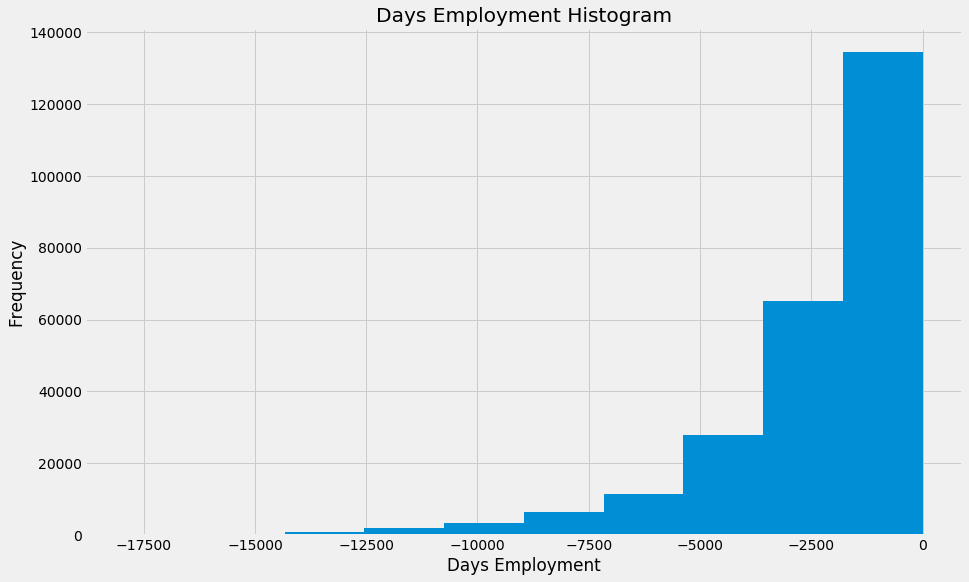

In [77]:
# Create an anomalous flag column
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [78]:
(train['DAYS_EMPLOYED'] / 365*-1).describe()

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [79]:
# Missing values statistics
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [80]:
#train.dtypes.value_counts()

In [81]:
# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

In [82]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


In [83]:
# Join to the training dataframe BureauBalance_by_client
train = train.merge(BureauBalance_by_client, on = 'SK_ID_CURR', how = 'left')
#train.head()
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,1.875000,3.0,0.0,15.0,8.0,0.161932,0.500000,0.000000,1.295455
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,4.0,3.250000,13.0,0.0,13.0,4.0,0.135417,0.541667,0.000000,0.541667
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,1.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000


In [84]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [85]:
#train.dtypes.value_counts()

In [86]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.178919
EXT_SOURCE_2                                      -0.160472
EXT_SOURCE_1                                      -0.155317
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.080193
client_bureau_balance_MONTHS_BALANCE_count_max    -0.068792
                                                     ...   
DAYS_EMPLOYED                                      0.074958
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076424
DAYS_BIRTH                                         0.078239
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089038
TARGET                                             1.000000
Name: TARGET, Length: 212, dtype: float64

In [87]:
# Join to the training dataframe BureauAgregado_by_loan
train = train.merge(BureauAgregado_by_loan, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.0,-1074.000,-1074.0,-1074.0,-1074.0,0.0,NaN,NaN,NaN,0.0
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,8.0,-789.500,-12.0,-1805.0,-6316.0,0.0,NaN,NaN,NaN,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,4.0,-193.000,-8.0,-413.0,-772.0,0.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418516,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418517,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418518,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418519,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
#train.dtypes.value_counts()

In [89]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [90]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.179433
EXT_SOURCE_2                                      -0.159119
EXT_SOURCE_1                                      -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.081162
CREDIT_ACTIVE_Closed_count_norm                   -0.079369
                                                     ...   
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076891
CREDIT_ACTIVE_Active_count_norm                    0.077356
DAYS_BIRTH                                         0.078222
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089774
TARGET                                             1.000000
Name: TARGET, Length: 318, dtype: float64

In [91]:
# Join to the training dataframe installments_payments_by_client
train = train.merge(installments_payments_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4.394101e+06,4.394101e+06,1.134881e+07,1.134881e+07
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4.394101e+06,4.394101e+06,1.134881e+07,1.134881e+07
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,16071.750,16071.750,21288.465,21288.465,21288.465,21288.465,3.172190e+04,3.172190e+04,6.386540e+04,6.386540e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418516,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,46241.370,46241.370,52450.470,52450.470,52450.470,52450.470,8.970507e+04,8.970507e+04,3.671533e+05,3.671533e+05
418517,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,60281.280,60281.280,60419.205,60419.205,60419.205,60419.205,6.044679e+04,6.044679e+04,3.625152e+05,3.625152e+05
418518,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,41805.990,61529.040,33413.760,33413.760,57622.815,61595.910,6.166174e+04,6.166174e+04,3.048921e+05,3.247575e+05
418519,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,194556.825,194556.825,171592.425,171592.425,194556.825,194556.825,1.945568e+05,1.945568e+05,1.773976e+06,1.773976e+06


In [92]:
#train.dtypes.value_counts()

In [93]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [94]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.179433
EXT_SOURCE_2                                      -0.159119
EXT_SOURCE_1                                      -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.081162
CREDIT_ACTIVE_Closed_count_norm                   -0.079369
                                                     ...   
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076891
CREDIT_ACTIVE_Active_count_norm                    0.077356
DAYS_BIRTH                                         0.078222
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089774
TARGET                                             1.000000
Name: TARGET, Length: 424, dtype: float64

In [95]:
# Join to the training dataframe POS_CASH_balance_by_client
train = train.merge(POS_CASH_balance_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_MONTHS_BALANCE_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,456.0,456.0,456.000,456.0,361.0,361.0,361.0,5415.0,8664.0
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,456.0,456.0,456.000,456.0,361.0,361.0,361.0,5415.0,8664.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,288.0,248.0,283.000,288.0,272.0,272.0,272.0,1608.0,2840.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,288.0,248.0,283.000,288.0,272.0,272.0,272.0,1608.0,2840.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,16.0,12.0,15.000,16.0,16.0,16.0,16.0,36.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418516,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,72.0,63.0,70.875,72.0,72.0,72.0,81.0,315.0,567.0
418517,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,42.0,42.0,42.000,42.0,49.0,49.0,49.0,147.0,294.0
418518,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,30.0,74.0,114.0,114.000,114.0,101.0,101.0,101.0,219.0,630.0
418519,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,298.0,298.0,298.000,298.0,202.0,202.0,202.0,2061.0,2990.0


In [96]:
#train.dtypes.value_counts()

In [97]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [98]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.179433
EXT_SOURCE_2                                      -0.159119
EXT_SOURCE_1                                      -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.081162
CREDIT_ACTIVE_Closed_count_norm                   -0.079369
                                                     ...   
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076891
CREDIT_ACTIVE_Active_count_norm                    0.077356
DAYS_BIRTH                                         0.078222
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089774
TARGET                                             1.000000
Name: TARGET, Length: 518, dtype: float64

In [99]:
# Join to the training dataframe credit_card_balance_by_client
train = train.merge(credit_card_balance_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418516,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418517,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418518,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418519,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
#train.dtypes.value_counts()

In [101]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [102]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                       -0.179433
EXT_SOURCE_2                                       -0.159119
EXT_SOURCE_1                                       -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean    -0.081162
CREDIT_ACTIVE_Closed_count_norm                    -0.079369
                                                      ...   
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean    0.106478
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max     0.107244
TARGET                                              1.000000
client_credit_SK_DPD_min_mean                            NaN
client_credit_SK_DPD_min_sum                             NaN
Name: TARGET, Length: 849, dtype: float64

In [103]:
# Join to the training dataframe previous_application_ag
train = train.merge(previous_application_ag, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.00,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.00,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418516,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
418517,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
418518,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1.00,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
418519,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,1.00,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [106]:
#train.dtypes.value_counts()

float64    809
int64       41
object      16
float32     14
bool         1
dtype: int64

In [107]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

Your selected dataframe has 881 columns.
There are 758 columns that have missing values.


,Missing Values,% of Total Values
previous_NAME_CONTRACT_TYPE_Cash loans_count,9590,100.0
previous_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Audio/Video_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Medical Supplies_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Tourism_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Consumer Electronics_sum,9590,100.0
previous_NAME_TYPE_SUITE_Other_B_sum,9590,100.0
previous_NAME_SELLER_INDUSTRY_Tourism_sum,9590,100.0
previous_WEEKDAY_APPR_PROCESS_START_SUNDAY_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_sum,9590,100.0


In [108]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                     -0.149444
EXT_SOURCE_2                                     -0.131821
EXT_SOURCE_1                                     -0.129646
client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_sum    -0.093719
client_bureau_balance_MONTHS_BALANCE_count_max   -0.083086
                                                    ...   
previous_NAME_GOODS_CATEGORY_Mobile_sum                NaN
previous_NAME_TYPE_SUITE_Unaccompanied_sum             NaN
previous_NAME_SELLER_INDUSTRY_Connectivity_sum         NaN
previous_CHANNEL_TYPE_Country-wide_sum                 NaN
previous_NAME_CONTRACT_TYPE_Cash loans_count           NaN
Name: TARGET, Length: 865, dtype: float64

In [109]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 previous_CHANNEL_TYPE_Stone_sum                               NaN
previous_PRODUCT_COMBINATION_POS industry with interest_sum   NaN
previous_NAME_CLIENT_TYPE_XNA_sum                             NaN
previous_NAME_TYPE_SUITE_Family_sum                           NaN
previous_NAME_GOODS_CATEGORY_Computers_sum                    NaN
previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum              NaN
previous_NAME_PAYMENT_TYPE_Cash through the bank_sum          NaN
previous_WEEKDAY_APPR_PROCESS_START_MONDAY_sum                NaN
previous_NAME_PAYMENT_TYPE_XNA_sum                            NaN
previous_NAME_CLIENT_TYPE_Refreshed_sum                       NaN
previous_NAME_GOODS_CATEGORY_Mobile_sum                       NaN
previous_NAME_TYPE_SUITE_Unaccompanied_sum                    NaN
previous_NAME_SELLER_INDUSTRY_Connectivity_sum                NaN
previous_CHANNEL_TYPE_Country-wide_sum                        NaN
previous_NAME_CONTRACT_TYPE_Cash loans_count   

In [110]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_TYPE_SUITE_Unaccompanied_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
0,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9586,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9587,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9588,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [112]:
#8-Cargo fichero application_test.csv y veo cabecera
test = pd.read_csv('/Users/LENOVO/Downloads/application_test.csv', delimiter= ',' , header=0)
test = test.dropna()
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
15,100107,Cash loans,M,Y,Y,0,180000.0,296280.0,21690.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
18,100128,Cash loans,F,Y,Y,1,225000.0,431280.0,23526.0,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,4.0
73,100561,Cash loans,M,Y,Y,0,180000.0,67500.0,8140.5,67500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
86,100699,Cash loans,M,Y,Y,1,225000.0,323460.0,23134.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
102,100770,Cash loans,M,Y,N,0,202500.0,697500.0,33687.0,697500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48628,455243,Cash loans,F,Y,Y,1,112500.0,252531.0,26005.5,234000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
48670,455607,Cash loans,M,Y,Y,0,387000.0,350415.0,25051.5,292500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0
48682,455703,Cash loans,F,Y,Y,1,450000.0,790830.0,57676.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48707,455940,Cash loans,M,Y,Y,0,202500.0,225000.0,19242.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0


In [113]:
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (test["DAYS_EMPLOYED_ANOM"].sum(), len(test)))

There are 0 anomalies in the test data out of 1739 entries


In [114]:
test.dtypes.value_counts()

float64    65
int64      40
object     16
bool        1
dtype: int64

In [115]:
missing_values = missing_values_table(test)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [116]:
# Create a label encoder object
le = preprocessing.LabelEncoder()
le_count = 0

In [117]:
# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

5 columns were label encoded.


In [118]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test  = pd.get_dummies(test )

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (9590, 990)
Testing Features shape:  (1739, 229)


In [119]:
#Alineamos set de datos
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (9590, 229)
Testing Features shape:  (1739, 228)


In [120]:
#Función para eliminar variables colineales
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
#corr_matrix.head()
corr_matrix

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
SK_ID_CURR,1.000000,0.008575,0.013943,NaN,0.005278,0.005066,0.011009,0.012280,0.029963,0.014715,...,0.010672,0.025292,0.018855,0.003493,0.016484,0.023249,0.013228,0.000434,0.007198,0.020304
NAME_CONTRACT_TYPE,0.008575,1.000000,0.001639,NaN,0.071921,0.019699,0.028713,0.234214,0.262251,0.200086,...,0.025521,0.006107,0.010262,0.011194,0.002221,0.002266,0.017576,0.014144,0.013803,0.043676
CODE_GENDER,0.013943,0.001639,1.000000,NaN,0.052692,0.020956,0.101930,0.037113,0.002879,0.036434,...,0.013469,0.001224,0.014884,0.000858,0.006185,0.016164,0.022401,0.010651,0.002437,0.032292
FLAG_OWN_CAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,0.005278,0.071921,0.052692,NaN,1.000000,0.030509,0.001466,0.041198,0.012320,0.047228,...,0.001950,0.003812,0.002599,0.006694,0.008960,0.009034,0.011244,0.014166,0.004127,0.004546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WALLSMATERIAL_MODE_Others,0.023249,0.002266,0.016164,NaN,0.009034,0.014486,0.006623,0.012755,0.016784,0.016225,...,0.008519,0.030118,0.028939,0.012244,0.014396,1.000000,0.105600,0.089445,0.015064,0.000299
WALLSMATERIAL_MODE_Panel,0.013228,0.017576,0.022401,NaN,0.011244,0.003694,0.030331,0.020976,0.028763,0.020303,...,0.041531,0.058182,0.251784,0.106525,0.125251,0.105600,1.000000,0.778218,0.131061,0.010868
"WALLSMATERIAL_MODE_Stone, brick",0.000434,0.014144,0.010651,NaN,0.014166,0.006518,0.064809,0.033981,0.048455,0.031799,...,0.045340,0.018643,0.213267,0.090229,0.106091,0.089445,0.778218,1.000000,0.111011,0.019155
WALLSMATERIAL_MODE_Wooden,0.007198,0.013803,0.002437,NaN,0.004127,0.006002,0.001572,0.023849,0.008859,0.026695,...,0.009641,0.052005,0.035917,0.015196,0.017867,0.015064,0.131061,0.111011,1.000000,0.007023


In [121]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#upper.head()
upper

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
SK_ID_CURR,NaN,0.008575,0.013943,NaN,0.005278,0.005066,0.011009,0.012280,0.029963,0.014715,...,0.010672,0.025292,0.018855,0.003493,0.016484,0.023249,0.013228,0.000434,0.007198,0.020304
NAME_CONTRACT_TYPE,NaN,NaN,0.001639,NaN,0.071921,0.019699,0.028713,0.234214,0.262251,0.200086,...,0.025521,0.006107,0.010262,0.011194,0.002221,0.002266,0.017576,0.014144,0.013803,0.043676
CODE_GENDER,NaN,NaN,NaN,NaN,0.052692,0.020956,0.101930,0.037113,0.002879,0.036434,...,0.013469,0.001224,0.014884,0.000858,0.006185,0.016164,0.022401,0.010651,0.002437,0.032292
FLAG_OWN_CAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,NaN,0.030509,0.001466,0.041198,0.012320,0.047228,...,0.001950,0.003812,0.002599,0.006694,0.008960,0.009034,0.011244,0.014166,0.004127,0.004546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WALLSMATERIAL_MODE_Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.105600,0.089445,0.015064,0.000299
WALLSMATERIAL_MODE_Panel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.778218,0.131061,0.010868
"WALLSMATERIAL_MODE_Stone, brick",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111011,0.019155
WALLSMATERIAL_MODE_Wooden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007023


In [122]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 35 columns to remove.


In [267]:
to_drop

['AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']

In [123]:
#Elimino variables colineales
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (9590, 194)
Testing shape:  (1739, 193)


In [124]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                           -0.149444
EXT_SOURCE_2                           -0.131821
EXT_SOURCE_1                           -0.129646
NAME_EDUCATION_TYPE_Higher education   -0.054774
NAME_CONTRACT_TYPE                     -0.043676
                                          ...   
FLAG_OWN_CAR                                 NaN
FLAG_MOBIL                                   NaN
FLAG_DOCUMENT_2                              NaN
FLAG_DOCUMENT_4                              NaN
DAYS_EMPLOYED_ANOM                           NaN
Name: TARGET, Length: 194, dtype: float64

In [125]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 NAME_HOUSING_TYPE_With parents         0.030194
CODE_GENDER                            0.032292
AMT_REQ_CREDIT_BUREAU_YEAR             0.033083
ORGANIZATION_TYPE_Transport: type 3    0.034979
OCCUPATION_TYPE_Laborers               0.038861
DAYS_BIRTH                             0.042169
REGION_RATING_CLIENT                   0.049486
FLAG_DOCUMENT_3                        0.054571
DAYS_EMPLOYED                          0.063844
TARGET                                 1.000000
FLAG_OWN_CAR                                NaN
FLAG_MOBIL                                  NaN
FLAG_DOCUMENT_2                             NaN
FLAG_DOCUMENT_4                             NaN
DAYS_EMPLOYED_ANOM                          NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.149444
EXT_SOURCE_2                           -0.131821
EXT_SOURCE_1                           -0.129646
NAME_EDUCATION_TYPE_Higher education   -0.054

In [126]:
train.shape


(9590, 194)

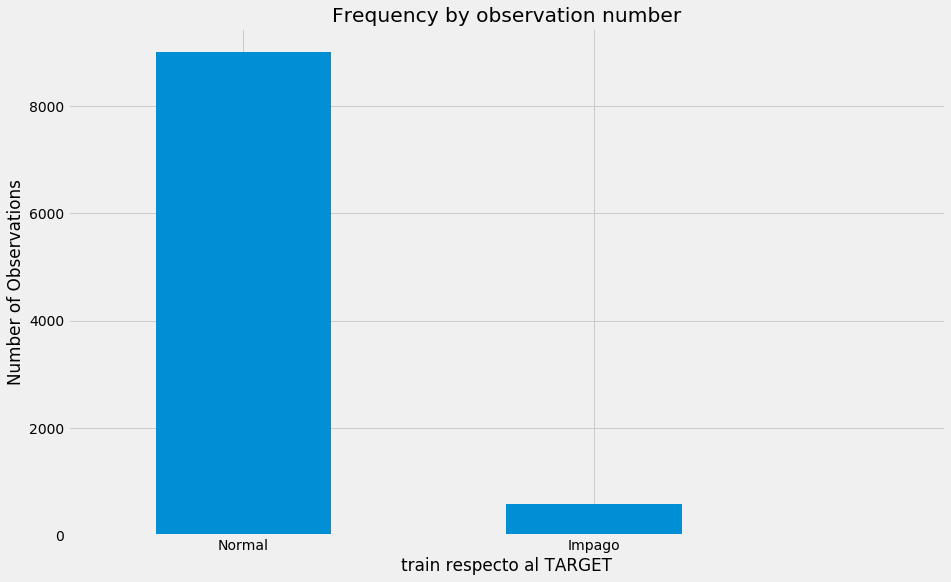

In [152]:
#El gráfico nos  muestra nuestro dataset esta desbalanceado 
count_classes = pd.value_counts(train['TARGET'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(3), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("train respecto al TARGET")
plt.ylabel("Number of Observations");

In [128]:
#Creamos Dataset de train
normal_df = train[train.TARGET == 0] #registros normales
impago_df = train[train.TARGET == 1] #casos de impago

In [129]:
normal_df.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
count,9000.000000,9000.000000,9000.000000,9000.0,9000.000000,9000.000000,9.000000e+03,9.000000e+03,9000.000000,9000.000000,...,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.0
mean,277930.985333,0.101556,0.504000,0.0,0.689556,0.605778,2.242129e+05,7.018143e+05,31842.664500,0.023464,...,0.005556,0.005556,0.064778,0.012556,0.017444,0.012000,0.480222,0.394889,0.018111,0.0
std,103344.785699,0.302080,0.500012,0.0,0.462701,0.779167,1.406989e+05,4.668230e+05,16663.377432,0.016388,...,0.074332,0.074332,0.246147,0.111352,0.130928,0.108891,0.499636,0.488854,0.133361,0.0
min,100083.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.375000e+04,4.500000e+04,2317.500000,0.000290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,187647.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.350000e+05,3.141000e+05,19867.500000,0.010556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,275847.000000,0.000000,1.000000,0.0,1.000000,0.000000,2.025000e+05,5.903370e+05,29333.250000,0.020246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,369651.000000,0.000000,1.000000,0.0,1.000000,1.000000,2.700000e+05,9.611460e+05,40702.500000,0.030755,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0
max,456226.000000,1.000000,1.000000,0.0,1.000000,5.000000,4.500000e+06,4.050000e+06,225000.000000,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [132]:
#normal_df.EXT_SOURCE_3

In [130]:
impago_df.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
count,590.000000,590.000000,590.000000,590.0,590.000000,590.000000,5.900000e+02,5.900000e+02,590.000000,590.000000,...,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.0
mean,286664.677966,0.047458,0.571186,0.0,0.698305,0.549153,2.004014e+05,6.685776e+05,31636.022034,0.022549,...,0.011864,0.006780,0.061017,0.006780,0.006780,0.011864,0.457627,0.433898,0.022034,1.0
std,103385.562730,0.212796,0.495326,0.0,0.459383,0.727900,1.040374e+05,4.158467e+05,14344.133825,0.014002,...,0.108368,0.082129,0.239565,0.082129,0.082129,0.108368,0.498624,0.496032,0.146918,0.0
min,100295.000000,0.000000,0.000000,0.0,0.000000,0.000000,5.985000e+04,5.094000e+04,3559.500000,0.001276,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,198244.750000,0.000000,0.000000,0.0,0.000000,0.000000,1.350000e+05,3.612240e+05,21613.500000,0.011657,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,295855.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.800000e+05,5.450400e+05,30332.250000,0.020246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,374969.750000,0.000000,1.000000,0.0,1.000000,1.000000,2.250000e+05,8.542721e+05,39969.000000,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0
max,456140.000000,1.000000,1.000000,0.0,1.000000,3.000000,1.170000e+06,2.695500e+06,85869.000000,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [134]:
#impago_df.EXT_SOURCE_3

In [135]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Text(0.5, 1.0, 'Number of observations per class')

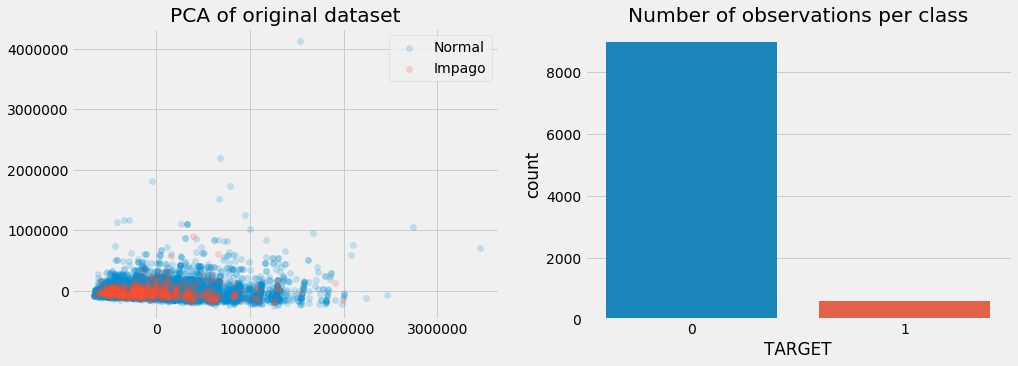

In [136]:
# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="Normal", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="Impago", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sn.countplot(y)
ax[1].set_title('Number of observations per class')

In [137]:
#Función para mostrar grafico de resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sn.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True TARGET')
    plt.xlabel('Predicted TARGET')
    plt.show()
    print (classification_report(y_test, pred_y))

In [153]:
#Parametros grafico
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Impago"]

In [139]:
#1-Ejecutamos Modelo con LogisticRegresion sin balancear
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

In [140]:
#Modelo 
model = run_model(X_train, X_test, y_train, y_test)

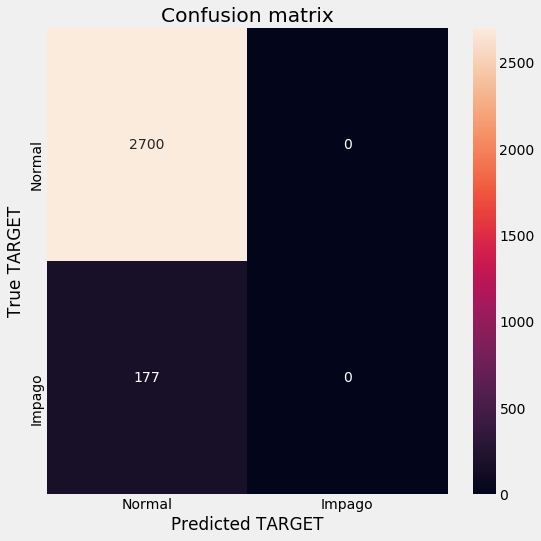

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2700
           1       0.00      0.00      0.00       177

    accuracy                           0.94      2877
   macro avg       0.47      0.50      0.48      2877
weighted avg       0.88      0.94      0.91      2877



In [282]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [141]:
#2- Ejecutamos Modelo con LogisticRegresion balanceando el set de datos class_weight="balanced"
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

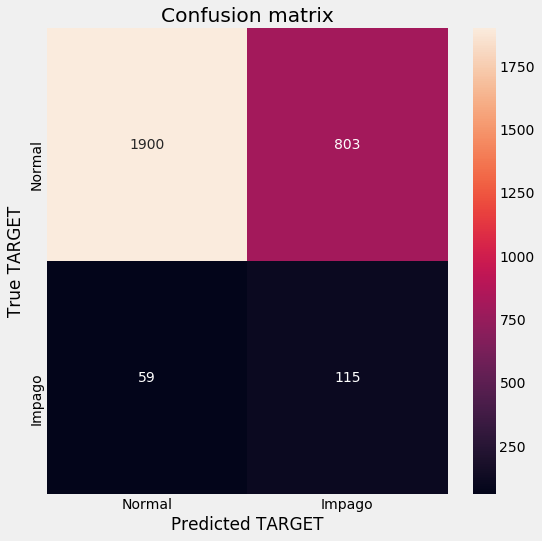

              precision    recall  f1-score   support

           0       0.97      0.70      0.82      2703
           1       0.13      0.66      0.21       174

    accuracy                           0.70      2877
   macro avg       0.55      0.68      0.51      2877
weighted avg       0.92      0.70      0.78      2877



In [142]:
#Probamos como responde en el test set
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [143]:
#3- Probamos con Random Forest

# Crear el modelo con 100 arboles
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,verbose=2,
                               max_features = 'sqrt')
# entrenar!
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=2, warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


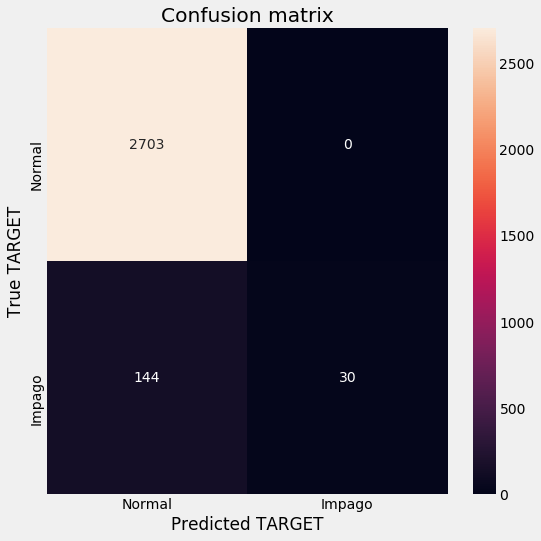

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2703
           1       1.00      0.17      0.29       174

    accuracy                           0.95      2877
   macro avg       0.97      0.59      0.63      2877
weighted avg       0.95      0.95      0.93      2877



In [144]:
#Revisamos los resultados
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [145]:
#4- Modelo RandomForestClassifier variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


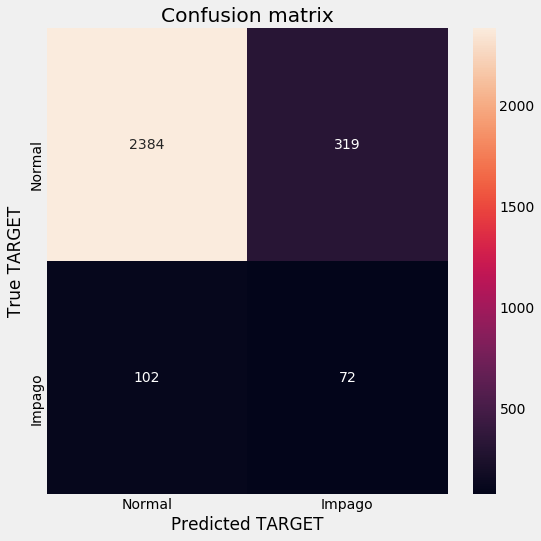

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2703
           1       0.18      0.41      0.25       174

    accuracy                           0.85      2877
   macro avg       0.57      0.65      0.59      2877
weighted avg       0.91      0.85      0.88      2877



In [146]:
#Vemos la Confusion Matrix con el conjunto de Test
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [147]:
#df = pd.DataFrame({'algorithm' : ['LogisticRegresion sin balancear', 'LogisticRegresion balanceado', 'Random Forest',
#                                 'RandomForestClassifier'],
#                   'precision' : [0, 0.12, 1.0, 0.16],
#                   'recall' : [0, 0.68, 0.12, 0.38]})

#df['overall'] = df.apply(lambda row: (row.precision + row.recall)/2, axis=1)

#df = df.sort_values(['overall'], ascending=True)
#df

In [148]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, pred_y)

In [149]:
print(roc_value)

0.6478880426601349
